# **Requirement 1**

First, import general modules and utility functions

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils.util_functions import rescale

Then, import the required environments, agents and auctions.

In [2]:
from environments.pricing_environment import PricingEnvironment
from utils.rbf_gaussian_process import RBFGaussianProcess
from agents.ucb_like.gp_ucb import GPUCBAgent
from agents.ucb_like.ucb1 import UCB1Agent
from agents.multiplicative_pacing.mult_pacing import MultiplicativePacingAgent
from auctions.second_price import SecondPriceAuction

### **Pricing problem**

In [3]:
# Parameters definition
max_price = 20
min_price = 10
cost = min_price # I set the cost to min price because that is the worst case for the seller (0 profit on a sale)
T = 365
daily_customers = 100
K = 100 # discretization intervals

conversion_probability = lambda p: 1-p/max_price #linear demand curve
reward_function = lambda price, cost, n_sales: (price - cost) * n_sales

prices = np.linspace(min_price,max_price, K) # 100 different prices between 10 and 20

# let's compute the clairvoyant: it is the repetition for T times of the maximum daily profit
daily_profit_curve = reward_function(prices, cost, daily_customers * conversion_probability(prices))
best_price_index = np.argmax(daily_profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(daily_profit_curve[best_price_index], T)

In [4]:
# Interaction between agent and environment
env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)
agent = GPUCBAgent(T)

agent_rewards = np.array([])
for t in range(T):
    p_t = agent.pull_arm()
    p_t = rescale(p_t, min_price, max_price)
    d_t, r_t = env.round(p_t, n_t=daily_customers)
    agent.update(r_t/daily_customers)
    agent_rewards = np.append(agent_rewards, r_t)

pricing_cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)

prices = rescale(agent.action_hist, min_price, max_price)
profits = agent.reward_hist

gp = RBFGaussianProcess(scale=2)
gp.fit(prices, profits)
mu, sigma = gp.predict(np.linspace(10,20,100))

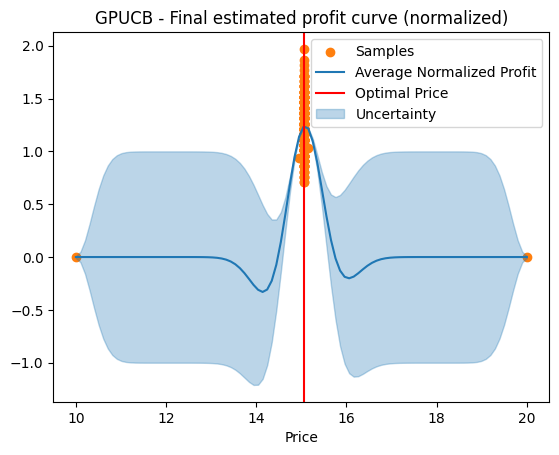

In [5]:
plt.scatter(prices, profits, label='Samples', color='C1')
plt.plot(np.linspace(10,20,100), mu, label='Average Normalized Profit')
plt.axvline(best_price, color='red',label='Optimal Price')
plt.fill_between(np.linspace(10,20,100), mu-sigma, mu+sigma, alpha=0.3, label='Uncertainty', color='C0')
plt.title('GPUCB - Final estimated profit curve (normalized)')
plt.xlabel('Price')
plt.legend()
plt.show();

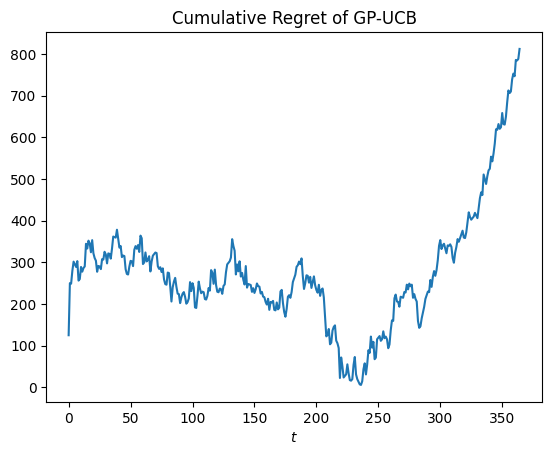

In [6]:
plt.figure()
plt.plot(pricing_cumulative_regret)
plt.title('Cumulative Regret of GP-UCB')
plt.xlabel('$t$')
plt.show();

### **Auction Problem**

In [7]:
# Utility function to generate gaussian samples (i need this to generate the other bidders distributions)
def generate_gaussian(mean, std_dev, num_samples, lower_bound=0, upper_bound=1):
    samples = []
    while len(samples) < num_samples:
        sample = np.random.normal(mean, std_dev)
        if lower_bound <= sample <= upper_bound:
            samples.append(sample)
    return samples

# Returns the best possible reward consdering at each round the best competing bid (m_t)
def get_clairvoyant_truthful(B, my_valuation, m_t, n_users):
    ## I compute my sequence of utilities at every round
    utility = (my_valuation-m_t)*(my_valuation>=m_t)
    ## Now I have to find the sequence of m_t summing up to budget B and having the maximum sum of utility
    ## In second price auctions, I can find the sequence **greedily**:
    sorted_round_utility = np.flip(np.argsort(utility)) # sorted rounds, from most profitable to less profitable
    clairvoyant_utilities = np.zeros(n_users)
    clairvoyant_bids= np.zeros(n_users)
    clairvoyant_payments = np.zeros(n_users)
    c = 0 #cumulative expenses
    i = 0
    while c <= B-1 and i < n_users: #until budget depletion and until end of auctions
        clairvoyant_bids[sorted_round_utility[i]] = 1 #i win the auctions starting from the most profitable one (to win i just bid 1 because i pay the next highest offer not mine)
        clairvoyant_utilities[sorted_round_utility[i]] = utility[sorted_round_utility[i]]
        clairvoyant_payments[sorted_round_utility[i]] = m_t[sorted_round_utility[i]]
        c += m_t[sorted_round_utility[i]]
        i+=1
    return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments

In [8]:
# environmental settings
T = 365
B = 150
n_advertisers = 4 # the learner is included in the advertisers
ctrs = np.ones(n_advertisers) # simplifying assumption: all ctrs are 1
my_valuation = 0.8

# Gaussian Competitors
other_bidders_mean = [0.5, 0.7, 0.8]
other_bidders_std_dev = [0.4, 0.3, 0.1]
other_bids = np.array([generate_gaussian(other_bidders_mean[i], other_bidders_std_dev[i], T) for i in range(n_advertisers - 1)])

# best competing bid at each round
m_t = other_bids.max(axis=0)

clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, T)

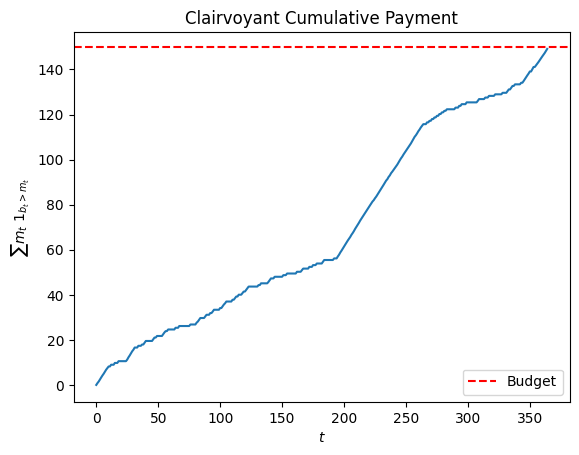

In [9]:
plt.title('Clairvoyant Cumulative Payment')
plt.plot(np.cumsum(clairvoyant_payments))
plt.axhline(B, color='red', linestyle='--', label='Budget')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\sum m_t~ 1_{b_t > m_t}$')
plt.show();

In [10]:
# Auction simulation
eta = 1/np.sqrt(T) # from theory
# auction_agent = MultiplicativePacingAgent(valuation=my_valuation, budget=B, T=T, eta=eta)
auction_agent = UCB1Agent(bids_set=np.linspace(0, 1, 10), valuation=my_valuation, budget=B, T=T) # 10 different possible bids between 0 and 1
auction = SecondPriceAuction(ctrs)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

for u in range(T):
    # interaction
    my_bid = auction_agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(winners==0)
    f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
    auction_agent.update(f_t, c_t)
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 69


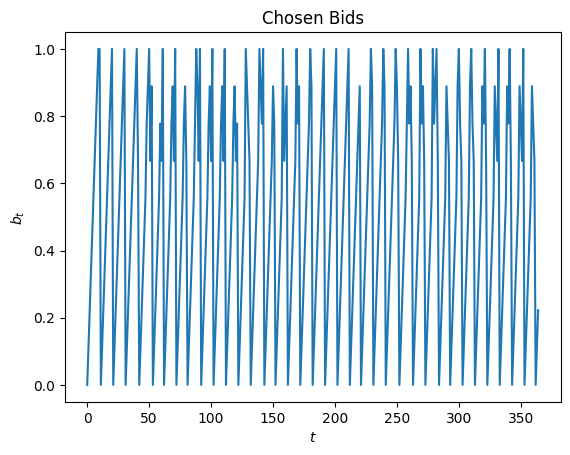

In [11]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

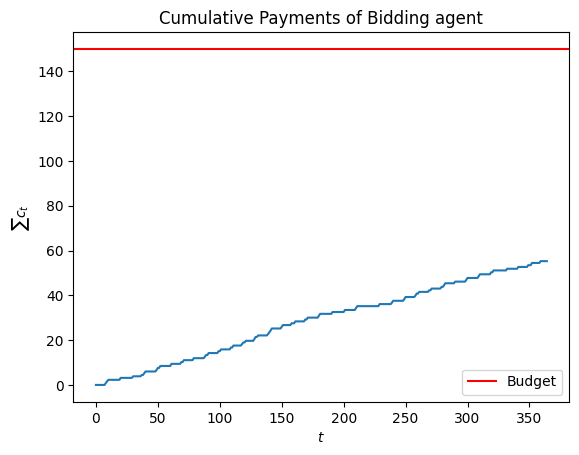

In [12]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Bidding agent')
plt.show()

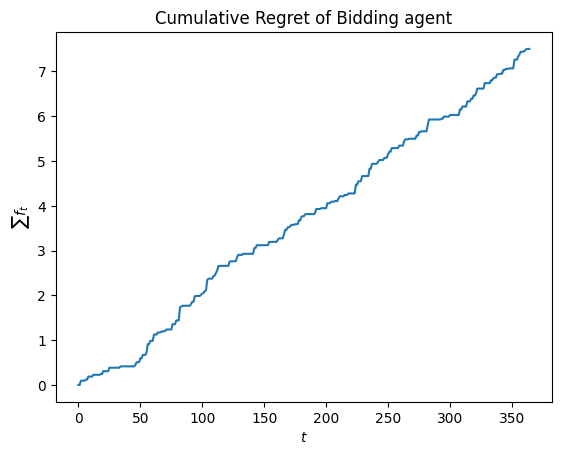

In [13]:
auction_cumulative_regret = np.cumsum(clairvoyant_utilities-utilities)
plt.plot(auction_cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('Cumulative Regret of Bidding agent')
plt.show()

### **Joint behaviour**

In [26]:
# Interaction between pricing and auction algorithms

n_runs = 4
cumulative_regret_per_trial = []

for run_idx in range(n_runs):
    print(f"Starting run {run_idx+1}")

    T = 1000
    daily_customers = 100
    eta = 1/np.sqrt(daily_customers * T) # from theory
    B = 150 * 3.5 * daily_customers # 150 units per day
    prices = np.linspace(min_price,max_price, 100) # 100 different prices between 10 and 20

    n_advertisers = 4 # the learner is included in the advertisers
    ctrs = np.ones(n_advertisers) # simplifying assumption: all ctrs are 1
    my_valuation = 0.8

    auction_agent = MultiplicativePacingAgent(valuation=my_valuation, budget=B,T=T * daily_customers, eta=eta)
    # auction_agent = UCB1Agent(bids_set=np.linspace(0, 1, 10), valuation=my_valuation, budget=B, T=T) # 10 different possible bids between 0 and 1
    auction = SecondPriceAuction(ctrs)

    pricing_agent = GPUCBAgent(T, discretization=100)
    env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)
    
    utilities = [[] for _ in range(T)]
    my_bids = [[] for _ in range(T)]
    my_payments = [[] for _ in range(T)]
    total_wins = np.zeros(T)

    expected_clairvoyant_rewards = np.array([])
    pricing_agent_rewards = np.array([])

    # generate other bids for every auction
    other_bids = np.array([generate_gaussian(other_bidders_mean[i], other_bidders_std_dev[i], T * daily_customers) for i in range(n_advertisers - 1)])
    m_t = other_bids.max(axis=0) # take the max competing bid for each auction

    for t in tqdm(range(T)): # each day
        
        p_t = pricing_agent.pull_arm() # choose a price
        p_t = rescale(p_t, min_price, max_price) # rescale the price

        for u in range(daily_customers): # each auction

            my_bid = auction_agent.bid() # bid for the auction
            bids = np.append(my_bid, other_bids[:, u].ravel())
            winners, payments_per_click = auction.round(bids=bids)
            my_win = int(winners==0)
            f_t, c_t = (my_valuation-m_t[u + t*daily_customers])*my_win, m_t[u + t*daily_customers]*my_win
            auction_agent.update(f_t, c_t)

            # logging
            utilities[t] = np.append(utilities[t], f_t)
            my_bids[t] = np.append(my_bids[t], my_bid)
            my_payments[t] = np.append(my_payments[t], c_t)
            total_wins[t] += my_win
                
        d_t, r_t = env.round(p_t, n_t=total_wins[t])
        if total_wins[t] != 0: # if total wins is 0, I don't update the pricing agent, so also self.t does not increase. It is possible to have a mismatch between the pricing agent t and T at the end of the simulation
            pricing_agent.update(r_t/total_wins[t])
        pricing_agent_rewards = np.append(pricing_agent_rewards, r_t)

        # compute the clairvoyant for each day
        daily_profit_curve = reward_function(prices, cost, total_wins[t] * conversion_probability(prices)) # the daily profit curve is calculated using the number of wins of the day
        best_price_index = np.argmax(daily_profit_curve)
        best_price = prices[best_price_index] # calculate the price that maximizes the profit each day
        expected_clairvoyant_rewards = np.append(expected_clairvoyant_rewards, daily_profit_curve[best_price_index])

    pricing_cumulative_regret = np.cumsum(expected_clairvoyant_rewards-pricing_agent_rewards)
    cumulative_regret_per_trial.append(pricing_cumulative_regret)

    print(f"Run {run_idx+1} completed")

Starting run 1


100%|██████████| 1000/1000 [00:42<00:00, 23.74it/s]


Run 1 completed
Starting run 2


100%|██████████| 1000/1000 [00:50<00:00, 19.63it/s]


Run 2 completed
Starting run 3


100%|██████████| 1000/1000 [00:39<00:00, 25.51it/s]


Run 3 completed
Starting run 4


100%|██████████| 1000/1000 [00:37<00:00, 26.40it/s]

Run 4 completed


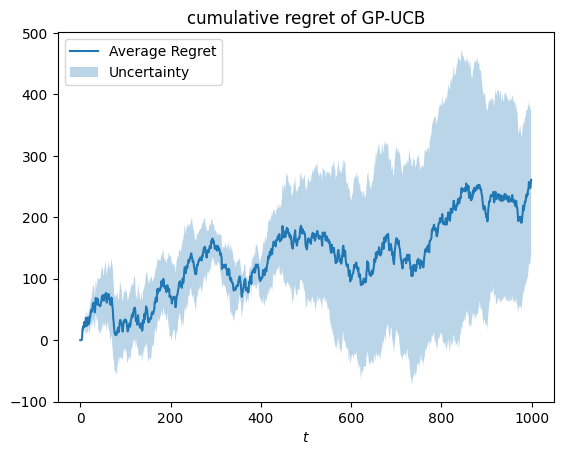

In [27]:
cumulative_regret_per_trial = np.array(cumulative_regret_per_trial)

average_regret = cumulative_regret_per_trial.mean(axis=0)
regret_sd = cumulative_regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of GP-UCB')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_runs),
                average_regret+regret_sd/np.sqrt(n_runs),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

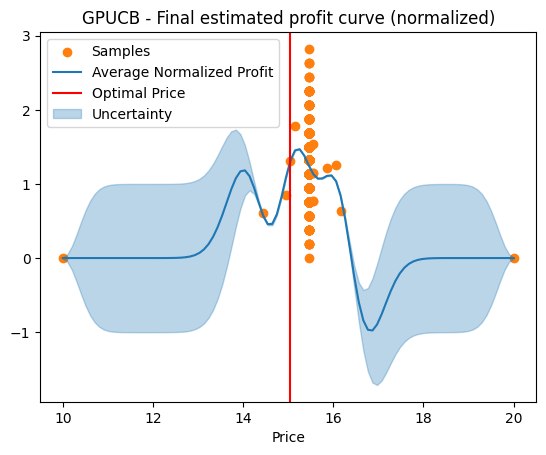

In [28]:
chosen_prices = rescale(pricing_agent.action_hist, min_price, max_price)
profits = pricing_agent.reward_hist
gp = RBFGaussianProcess(scale=2)
gp.fit(chosen_prices, profits)
mu, sigma = gp.predict(np.linspace(10,20,100))

plt.scatter(chosen_prices, profits, label='Samples', color='C1')
plt.plot(np.linspace(10,20,100), mu, label='Average Normalized Profit')
plt.axvline(best_price, color='red',label='Optimal Price')
plt.fill_between(np.linspace(10,20,100), mu-sigma, mu+sigma, alpha=0.3, label='Uncertainty', color='C0')
plt.title('GPUCB - Final estimated profit curve (normalized)')
plt.xlabel('Price')
plt.legend()
plt.show();

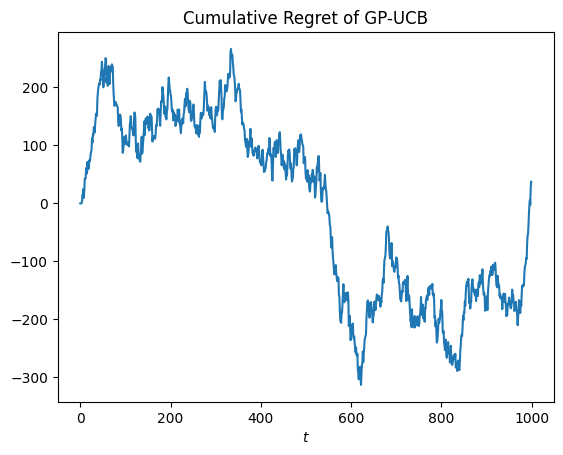

In [29]:
plt.figure()
plt.plot(pricing_cumulative_regret)
plt.title('Cumulative Regret of GP-UCB')
plt.xlabel('$t$')
plt.show();

In [30]:
clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, daily_customers * T)

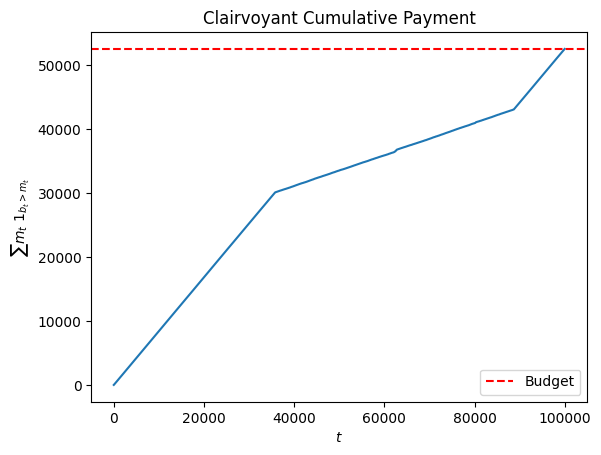

In [31]:
plt.title('Clairvoyant Cumulative Payment')
plt.plot(np.cumsum(clairvoyant_payments))
plt.axhline(B, color='red', linestyle='--', label='Budget')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\sum m_t~ 1_{b_t > m_t}$')
plt.show();

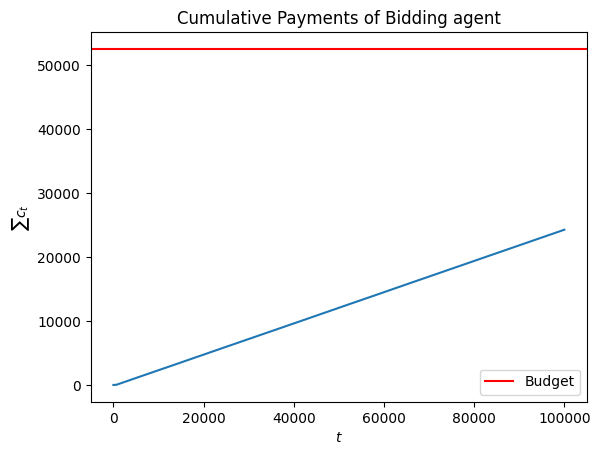

In [32]:
flatten_payments = np.array(my_payments).flatten()
cumulative_payments = np.cumsum(flatten_payments)

plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Bidding agent')
plt.show()

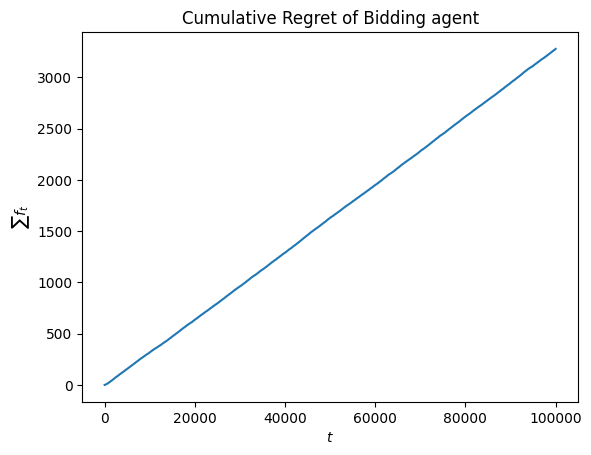

In [33]:
flatten_utilities = np.array(utilities).flatten()

auction_cumulative_regret = np.cumsum(clairvoyant_utilities-flatten_utilities)
plt.plot(auction_cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('Cumulative Regret of Bidding agent')
plt.show()